### clustering all the buurten - still WIP

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
### INTERMEZZO GET MAP ###
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
from pyogrio import read_dataframe

# first create a map which can be used later in the analysis
file_path = '../data/buurt_2020_v3.shp'
buurten_map = read_dataframe(file_path)
clean_up = True
provincie_utrecht_gemeente =[
    'Amersfoort',
    'Baarn',
    'Bunnik',
    'Bunschoten',
    'De Bilt',
    'De Ronde Venen',
    'Eemnes',
    'Houten',
    'Leusden',
    'Lopik',
    'Montfoort',
    'Nieuwegein',
    'Oudewater',
    'Renswoude',
    'Rhenen',
    'Soest',
    'Stichtse Vecht',
    'Utrecht',
    'Utrechtse Heuvelrug',
    'Veenendaal',
    'Vijfheerenlanden',
    'Wijk bij Duurstede',
    'Woerden',
    'Woudenberg',
    'IJsselstein',
    'Zeist']

deel_provincie_utrecht = ['Utrecht'] # houten

# gemeente_selectie = deel_provincie_utrecht
gemeente_selectie = provincie_utrecht_gemeente
gem_map = buurten_map.loc[buurten_map['GM_NAAM'].isin(gemeente_selectie)]

if clean_up:
    drop_buurten_houten = ['Buitengebied Houten West',
        'Buitengebied Houten Oost', "Dorp 't Goy", "'t Goyse Dorp",
        "Buitengebied 't Goy", "'t Waal", 'Tull',
        "Buitengebied Tull en 't Waal", 'Dorp Schalkwijk West',
        'Dorp Schalkwijk Oost', 'Buitengebied Schalkwijk West',
        'Buitengebied Schalkwijk Oost','Bruggen', 'Bogen', 'De Poel',
        'Schepen', 'Boten', 'Honen', 'Kaden', 'Vesten', 'De Staart',
        'Hof van Wulven', 'Rondweg Noord-Oost', 'Rondweg Noord-West',
        'Rondweg Zuid-Oost', 'Rondweg Zuid-West'] 

    drop_buurten_utrecht = [
        'Bedrijventerrein Lageweide',
        'Haarzuilens en omgeving',
        'Bedrijventerrein en omgeving',
        'Utrecht Science Park',
                'Bedrijvengebied Strijkviertel', 
                'Bedrijvengebied Papendorp',
                'Rijnenburg',
                'Poldergebied Overvecht' ,
                ]

    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_houten)]
    gem_map = gem_map.loc[~gem_map['BU_NAAM'].isin(drop_buurten_utrecht)]

### INTERMEZZO GET MAP ###

In [3]:
# get the dataset to do some clustering
df = pd.read_csv('../data/buurten.csv', index_col=0)

In [4]:
df.head(1)

,buurt_code,gm_naam,regio,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,...,leefbarometer_score,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg
0,BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.0,31.65


In [5]:
# create subselection of dataset
clean_buurten = gem_map['BU_CODE']
df = df.loc[df['buurt_code'].isin(clean_buurten)]

In [6]:
# df = df.drop(columns=['gm_naam', 'regio'])
df = df.dropna()

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 0 to 880
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   buurt_code                                  617 non-null    object 
 1   gm_naam                                     617 non-null    object 
 2   regio                                       617 non-null    object 
 3   aantal_inwoners                             617 non-null    int64  
 4   aantal_inwoners_tussen_25_44_percentage     617 non-null    float64
 5   aantal_huishoudens_met_kinderen_percentage  617 non-null    float64
 6   gemiddelde_huishoudensgrootte               617 non-null    float64
 7   woningvoorraad                              617 non-null    int64  
 8   gemiddelde_woningwaarde                     617 non-null    float64
 9   meergezinswoning_percentage                 617 non-null    float64
 10  bewoond_percen

In [8]:
df = df.set_index(['buurt_code','gm_naam', 'regio'])
df.head(1)

,,,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,bewoond_percentage,koopwoning_percentage,bouwjaar_vanaf_2000_percentage,...,leefbarometer_score,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg
buurt_code,gm_naam,regio,,,,,,,,,,,,,,,,,,,,,
BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,91.0,26.0,2.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.0,31.65


In [9]:
X = df.reset_index(drop=True)

In [10]:
X.head(1)

,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,bewoond_percentage,koopwoning_percentage,bouwjaar_vanaf_2000_percentage,...,leefbarometer_score,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg
0,710,36.62,5.63,1.4,396,335.0,69.0,91.0,26.0,2.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.0,31.65


In [11]:
print(len(X.columns))

31


In [12]:
#scale data
ss = StandardScaler()
X = ss.fit_transform(X)

In [13]:
# # # reduce pca to visualize results
pca = PCA(n_components=10)
X = pca.fit_transform(X)

# reduce technqiue with tsne
# tsne = TSNE(n_components=10, perplexity=15,method='exact',random_state=42, init='random', learning_rate=200)
# X = tsne.fit_transform(X)

In [14]:
## edit:
## determine best centriods:
## mean of cluster is determined = centroid
## each point is put in cluster > then  mean is calculated > variance within cluster is calculated 
## lowest variance within cluster is best mean cluster score so therefore new centroids are created in new iterations to deterime lowest overall variance

## then to determine optimal clusters:
## with more clusters we will always get more points that we catch with the lowest variance;but the point is that we have lowers variance with miniaml clusters (thats really winning).
# inertia per cluster measures how well the clusters represent the datapoints (distance from points to center as measurement)

In [15]:
from sklearn.cluster import KMeans
all = []
number_clusters = range(1,10)

# lets try different clustering and de elbow method to see what is optimal
for i in number_clusters:
    kmeans = KMeans(i, n_init=10)
    kmeans.fit(X)

    cluster_inertia = kmeans.inertia_   
    all.append(cluster_inertia)

/Users/nellekesmits/Documents/projects/notebook.buurtenrecommender/venv/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


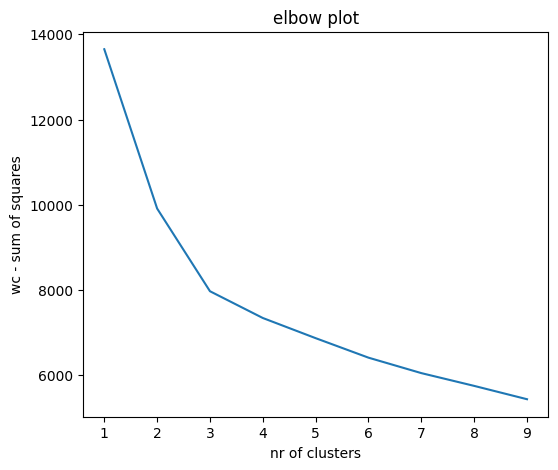

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.plot(number_clusters, all)
plt.title('elbow plot')
plt.xlabel('nr of clusters')
plt.ylabel('wc - sum of squares') #within cluster
plt.show()

In [17]:
## cut-off seems to be at 3
kmeans = KMeans(n_clusters=3)
output = kmeans.fit_transform(X)

/Users/nellekesmits/Documents/projects/notebook.buurtenrecommender/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
df.head()

,,,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,bewoond_percentage,koopwoning_percentage,bouwjaar_vanaf_2000_percentage,...,leefbarometer_score,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg
buurt_code,gm_naam,regio,,,,,,,,,,,,,,,,,,,,,
BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,91.0,26.0,2.0,...,4.22,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.00,31.65
BU03070101,Amersfoort,Nieuwstraat e.o.,460,32.61,8.70,1.6,259,420.0,61.0,93.0,41.0,11.0,...,4.26,0.02,-0.10,-0.03,0.24,1280.0,2600.0,0.09,20.00,27.01
BU03070102,Amersfoort,Mooierstraat e.o.,165,24.24,12.12,1.7,100,440.0,72.0,89.0,45.0,0.0,...,4.28,0.04,-0.11,-0.03,0.24,1350.0,2770.0,0.00,20.00,24.79
BU03070103,Amersfoort,Lieve Vrouwekerkhof,465,32.26,8.60,1.6,298,341.0,77.0,94.0,33.0,1.0,...,4.18,0.02,-0.18,-0.05,0.26,1170.0,2290.0,-0.04,20.00,30.61
BU03070104,Amersfoort,Coninckstraat e.o.,1255,33.86,8.76,1.6,772,308.0,48.0,95.0,29.0,5.0,...,4.22,0.01,-0.09,-0.04,0.22,1150.0,2300.0,-0.12,20.45,28.56


In [19]:
df['labels'] = kmeans.labels_ + 1

In [20]:
df['labels'].value_counts()

1    310
2    165
3    142
Name: labels, dtype: int64

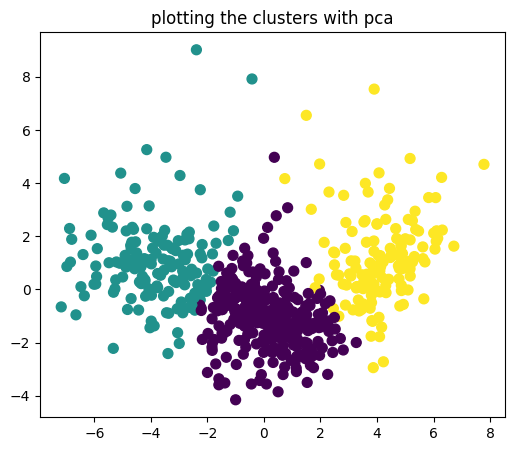

In [21]:
## Visualize with PCA

# reduce pca to visualize results
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

# Plot the clustered data
plt.figure(figsize=(6, 5))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title('plotting the clusters with pca')
# plt.savefig('scaling_pca_scatter_pca.png')
plt.show()


/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_29603/2023328205.py:18: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/nellekesmits/Documents/projects/notebook.buurtenrecommender/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_29603/2023328205.py:19: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


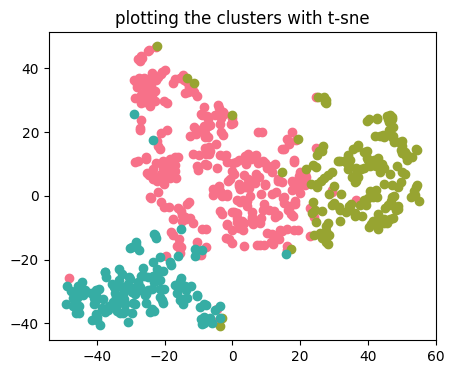

In [22]:
## Visualize with TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
x_tsne = tsne.fit_transform(X)

x = [x for x,y in x_tsne]
y = [y for x,y in x_tsne]

palette = sns.color_palette("husl", 4).as_hex() 

plt.figure(figsize=(5, 4))

for category, color in enumerate(palette):
    xs = np.array(x)[df.labels==category+1]
    ys = np.array(y)[df.labels==category+1]
    plt.scatter(xs, ys, color=color)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, color=color)
plt.title("plotting the clusters with t-sne")
# plt.savefig('scaling_pca_scatter_tsne.png')
plt.show()


In [23]:
output = df.reset_index()
output.head(1)

,buurt_code,gm_naam,regio,aantal_inwoners,aantal_inwoners_tussen_25_44_percentage,aantal_huishoudens_met_kinderen_percentage,gemiddelde_huishoudensgrootte,woningvoorraad,gemiddelde_woningwaarde,meergezinswoning_percentage,...,leefbarometer_fysieke_omgeving,leefbarometer_fysieke_overlast,leefbarometer_sociale_samenhang,leefbarometer_voorzieningen,aardgasverbruik_m3_gemiddeld,elektriciteitsverbruik_kwh_gemiddeld,social_economische_score_gemiddeld,geluid_van_treinverkeer,geluid_van_weg,labels
0,BU03070100,Amersfoort,Hof,710,36.62,5.63,1.4,396,335.0,69.0,...,0.02,-0.14,-0.04,0.24,1310.0,2430.0,-0.12,20.0,31.65,2


In [24]:
merged_df = gem_map.merge(output, left_on='BU_CODE', right_on='buurt_code', how='left')
merged_df.loc[merged_df['labels'].isna(), 'labels'] = 0
merged_df = merged_df.dropna(subset='labels')
merged_df['labels'].value_counts()

1.0    310
0.0    261
2.0    165
3.0    142
Name: labels, dtype: int64

In [29]:
import matplotlib as mpl
vmin, vmax = 0, 5

# cmap = mpl.colors.ListedColormap(["white", "red", "navy", "yellow"])
# cmap = mpl.colors.ListedColormap(["red", "navy"])
cmap = mpl.colors.ListedColormap(["white", "yellow", "red", "navy"])
# cmap = mpl.colors.ListedColormap(["white", "yellow", "red", "navy", "pink", "gold", "grey", "black", "green"])
norm = mpl.colors.BoundaryNorm(np.arange(vmin,vmax), cmap.N) 

/var/folders/1r/tdmn3kx53dxffhrmfbsld_4w0000gn/T/ipykernel_29603/1092463137.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


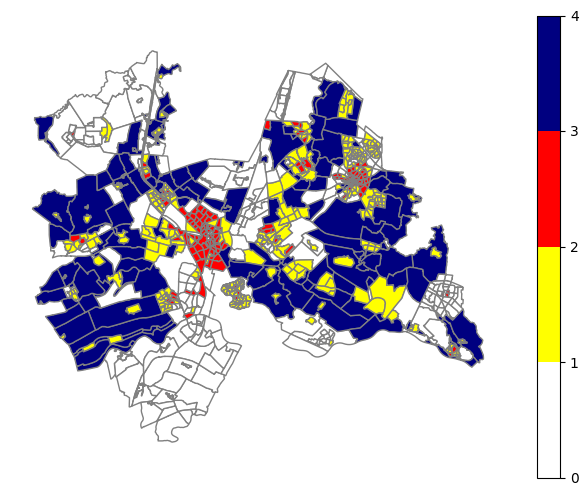

In [30]:
fig, ax = plt.subplots(1, figsize=(8, 6))

merged_df.plot(column="labels",
                    figsize = (6,4),
                    norm = norm,
                    cmap=cmap,
                    edgecolor='grey',
                    ax=ax)

# settings
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)
# plt.savefig('scaling_pca_map.png')
plt.show()

In [31]:
## see which gemeentes are in each cluster
for c_nr in output['labels'].unique():
    cluster = output.loc[output['labels'] == c_nr]
    print('de volgende gemeente worden gevonden voor cluster: ', c_nr)
    print(cluster['regio'].unique()) #gm_naam
    print('\n')

de volgende gemeente worden gevonden voor cluster:  2
['Hof' 'Nieuwstraat e.o.' 'Mooierstraat e.o.' 'Lieve Vrouwekerkhof'
 'Coninckstraat e.o.' 'Beestenmarkt' 'Grote Haag' 'Stadhuisplein'
 'Schimmelpenninckbuurt' 'Smallepad e.o.' 'Snouckaertlaan e.o.' 'Zonnehof'
 'Rivierenbuurt-West' 'Gerrit van Stellingwerfstraat e.o.'
 'Bloemenbuurt-Oost' 'Bloemenbuurt-West' 'Bomenbuurt' 'Puntenburg'
 'Piet Mondriaanlaan e.o.' 'Eemplein-Nieuwe Stad' 'Jericho / Jeruzalem'
 'Sterrenbeeldenbuurt' 'Gildekwartier' 'Kruiskamp-Noord'
 'Kruiskamp-Midden' 'Kruiskamp-Zuid' 'Vuurtoren' 'De Plaatsen'
 'Queekhoven e.o.' 'Zangvogelbuurt' 'De Horsten' 'Watervogelbuurt'
 'Liendert-Zuid' 'Schuilenburg-Midden' 'Schuilenburg-Noord'
 'Schuilenburg-Zuid' 'Willem III' 'Componistenbuurt-Noord'
 'Componistenbuurt-Midden' 'Componistenbuurt-Zuid'
 'Bekenstein / De Luiaard' 'Dorrestein' 'Westerstraat e.o.'
 'Juliana van Stolberg' 'Klein Zwitserland-Laag' 'Hoefkwartier'
 'Winkelcentrum Vathorst' 'Centrum' 'Nieuwe-Oosterhei' 'Am